---
title: A356 Lab 5 — Clustering 
subtitle: Searching for open stellar clusters in Gaia data 
authors:
  - name: Earl Patrick Bellinger
    orcid: 0000-0003-4456-4863
    affiliations:
      - Department of Astronomy, Yale University
license: CC-BY-4.0
---

*tags*: `clustering`, `big data`, `HDBSCAN`, `gaia`, `data-visualization`, `advanced-undergrad`

## Learning Goals 

In this lab, you will learn how to: 
1. Query the Gaia database 
2. Clean large data sets 
3. Search for substructure in a high-dimensional space 
4. Recognize a stellar cluster and visualize it in a salient way 

## Overview

The **Gaia mission** is a space observatory that was launched by the European Space Agency (ESA) in December 2013 with the objective of creating a precise three-dimensional map of our Milky Way Galaxy by measuring the positions, distances, and motions of over a billion stars. The mission operates by repeatedly scanning the sky and collecting high-precision astrometric, photometric, and spectroscopic data. 

**Clustering algorithms** are unsupervised machine learning techniques used to group data points based on their inherent similarities without predefined labels. By analyzing patterns and structures within datasets, these algorithms identify clusters where data points share common characteristics. This process reveals hidden substructures in the data, making clustering a powerful tool for exploratory data analysis. 

**Star clusters** are groups of stars that are gravitationally bound and have formed from the same molecular cloud, sharing similar ages and chemical compositions. They serve as fundamental building blocks in the study of stellar evolution and galactic structure. There are two primary types of star clusters: **open clusters** and **globular clusters**. Open clusters consist of a few dozen to several thousand young stars, and are typically found in the spiral arms of galaxies like the Milky Way. They are loosely bound and can disperse over time. Globular clusters, on the other hand, are densely packed, spherical collections containing hundreds of thousands to millions of old stars, residing mainly in the halos of galaxies. Observations suggest that some globular clusters may actually be the **remnant cores of dwarf galaxies** that have been stripped of their outer stars through gravitational interactions with larger galaxies such as the Milky Way, leaving behind a dense cluster of stars that resembles a globular cluster. 

In today's lab, we are going to apply a clustering algorithm, HDBSCAN, to a set of stars observed by Gaia. We will look for stars that have similar kinematic properties, thereby enabling us to algorithmically discover one or more star clusters. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42) # for reproducibility 

In [2]:
# some statements to make the figures look nicer 
%config InlineBackend.figure_format='retina'
plt.rcParams.update({'axes.linewidth' : 1,
                     'ytick.major.width' : 1,
                     'ytick.minor.width' : 1,
                     'xtick.major.width' : 1,
                     'xtick.minor.width' : 1,
                     'xtick.labelsize': 10, 
                     'ytick.labelsize': 10,
                     'axes.labelsize': 12,
                     'font.family': 'Serif',
                     'figure.figsize': (10, 6)
                    })

:::{note} Preliminary: data acquisition

I ran the following Gaia query to obtain approximately 1 million stars in an 8 degree circle centered on an RA and Dec of 58 and 25 degrees. The query takes about 5 minutes to run, so I saved you the trouble. You can find the data on canvas as `gaia.csv`. 

:::

```python
from astroquery.gaia import Gaia

adql_query = f"""
    SELECT
      g.source_id, g.ra, g.dec, 
      g.parallax, g.parallax_error, 
      g.pmra, g.pmra_error, g.pmdec, g.pmdec_error, 
      g.phot_g_mean_mag, g.phot_bp_mean_mag, g.phot_rp_mean_mag
    FROM gaiadr3.gaia_source AS g
    WHERE CONTAINS(
        POINT('ICRS', g.ra, g.dec),
        CIRCLE('ICRS', 58, 25, 8)
      ) = 1
    AND g.phot_bp_mean_mag IS NOT NULL
    AND g.phot_rp_mean_mag IS NOT NULL
    AND g.astrometric_params_solved = 31
    """

job = Gaia.launch_job_async(adql_query)
results = job.get_results()
results.write('gaia.csv', format='csv', overwrite=True)
```

:::{tip} Exercise 1

Let's get started by looking at this subset of the Gaia data. 

1. Parse `gaia.csv`, and take a look at the columns.
2. Sort the data frame by parallax in ascending order.
3. Plot the uncertainty in parallax and proper motions (see example below).
4. Make a cut at a parallax uncertainty of 0.1 mas (only retaining data below that cut). 
5. Re-make the previous plot to see the effect of the cut. 
:::

In [4]:
df = pd.read_table('gaia.csv', )
df

SOURCE_ID,ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag
0       60959467264952320,51.21167853124599,20.3882373...                                                                          
1       67282419337270912,58.49137020688505,25.4984165...                                                                          
2       63774423190205184,58.31300573210603,21.6689408...                                                                          
3       63774423190208768,58.317326601928876,21.676711...                                                                          
4       58115477361020672,53.29284993669423,20.5538700...                                                                          
...                                                   ...                                                                          
914857  149700608363720576,65.58126412262095,25.433409...                                                                          
914858  149700608363721600,65.57140415002728,25.431635...                                                                          
914859  149700638426309376,65.54866061445925,25.423178...                                                                          
914860  149700642723462272,65.54654782790364,25.425415...                                                                          
914861  149700672786050176,65.56856970559029,25.429542...                                                                          

[914862 rows x 1 columns]

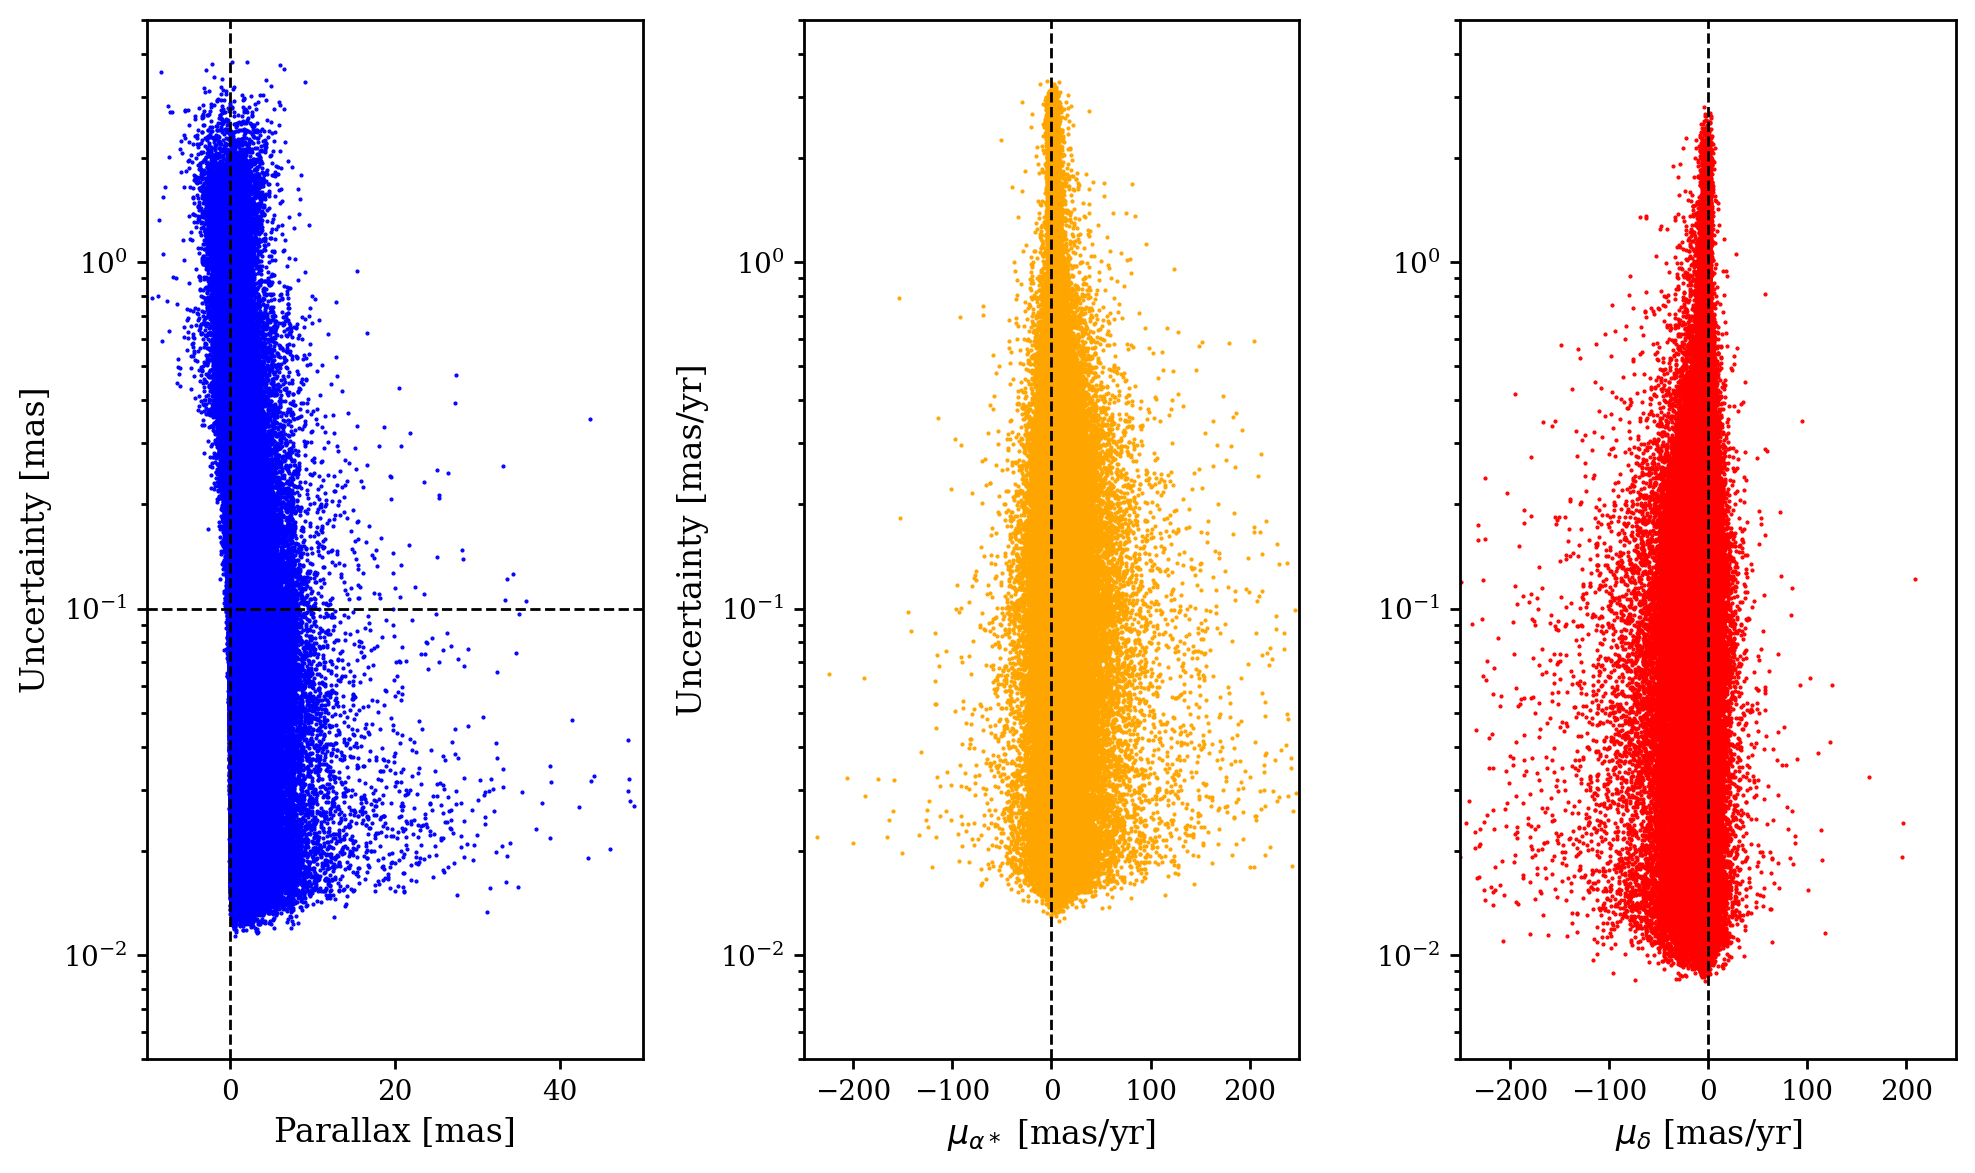

In [5]:
## Your code here 


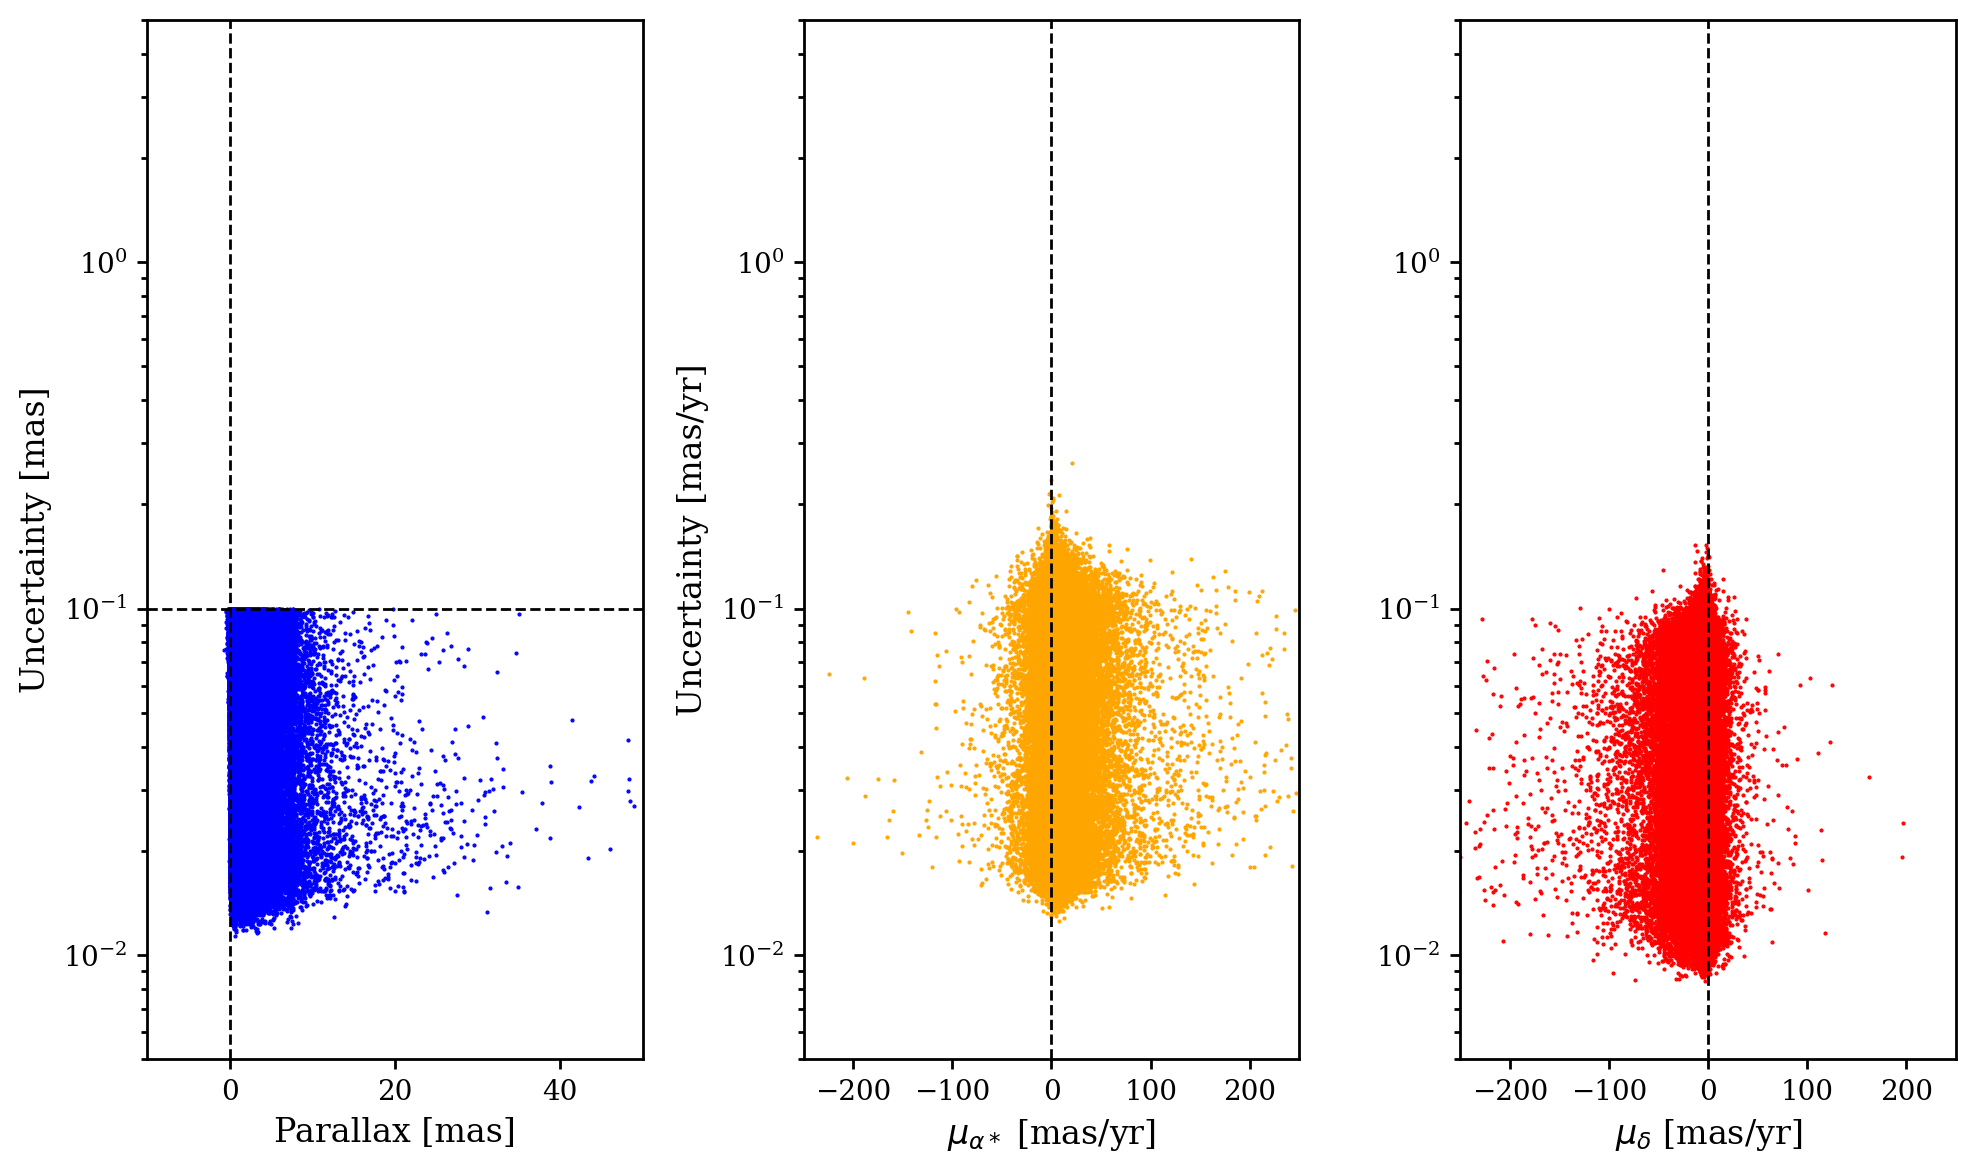

In [7]:
## Your code here 



:::{tip} Exercise 2

1. Plot the RA and Dec of all the stars, and color them by parallax. 
2. Plot the proper motions of all the stars, and color them by parallax. (Do you notice something sticking out in these dimensions?) 
3. Plot a color-magnitude diagram, colored by parallax. 

As always, set your plotting ranges as appropriate, choose an appropriate colorbar, and label all your axes. It is helpful to zoom in on the colorbar (i.e., set `vmin` and `vmax` in `plt.scatter`). 
:::

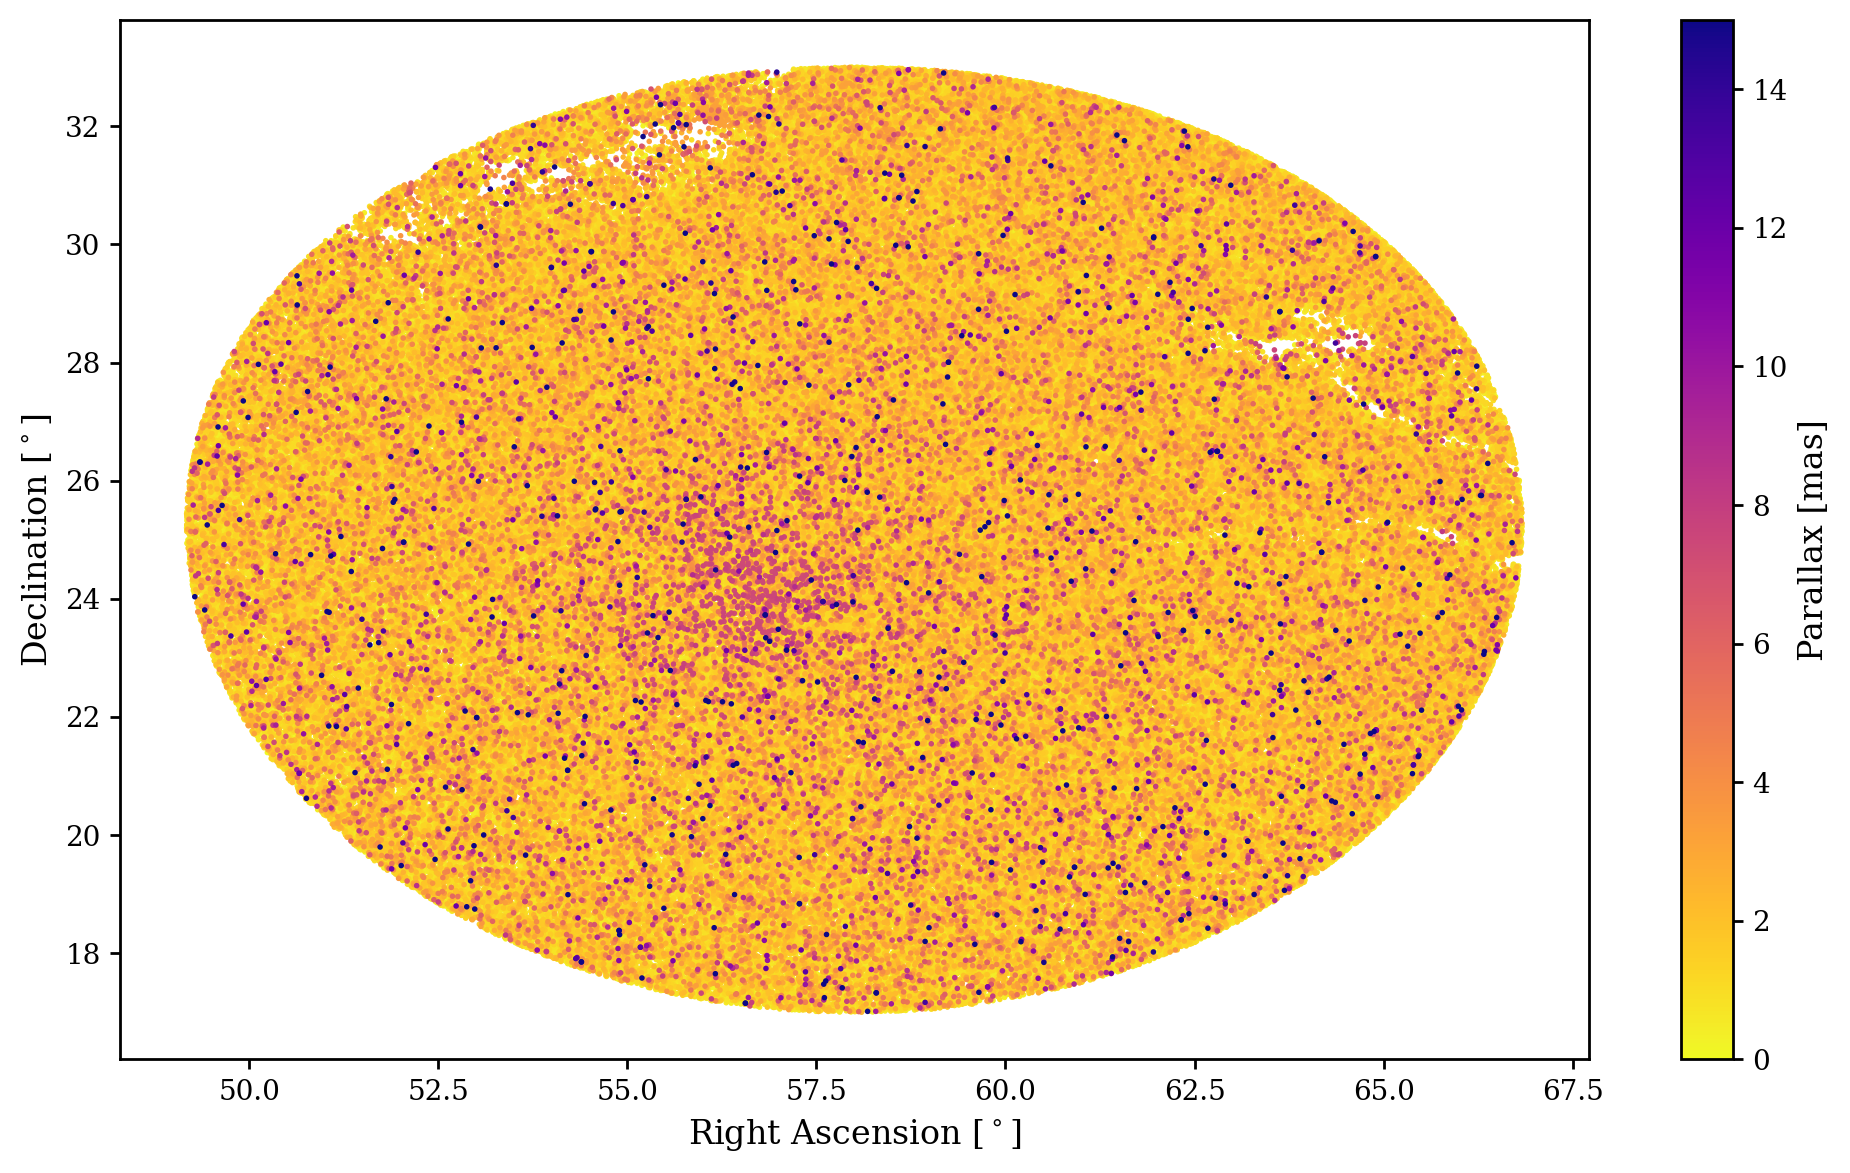

In [9]:
## Your code here 



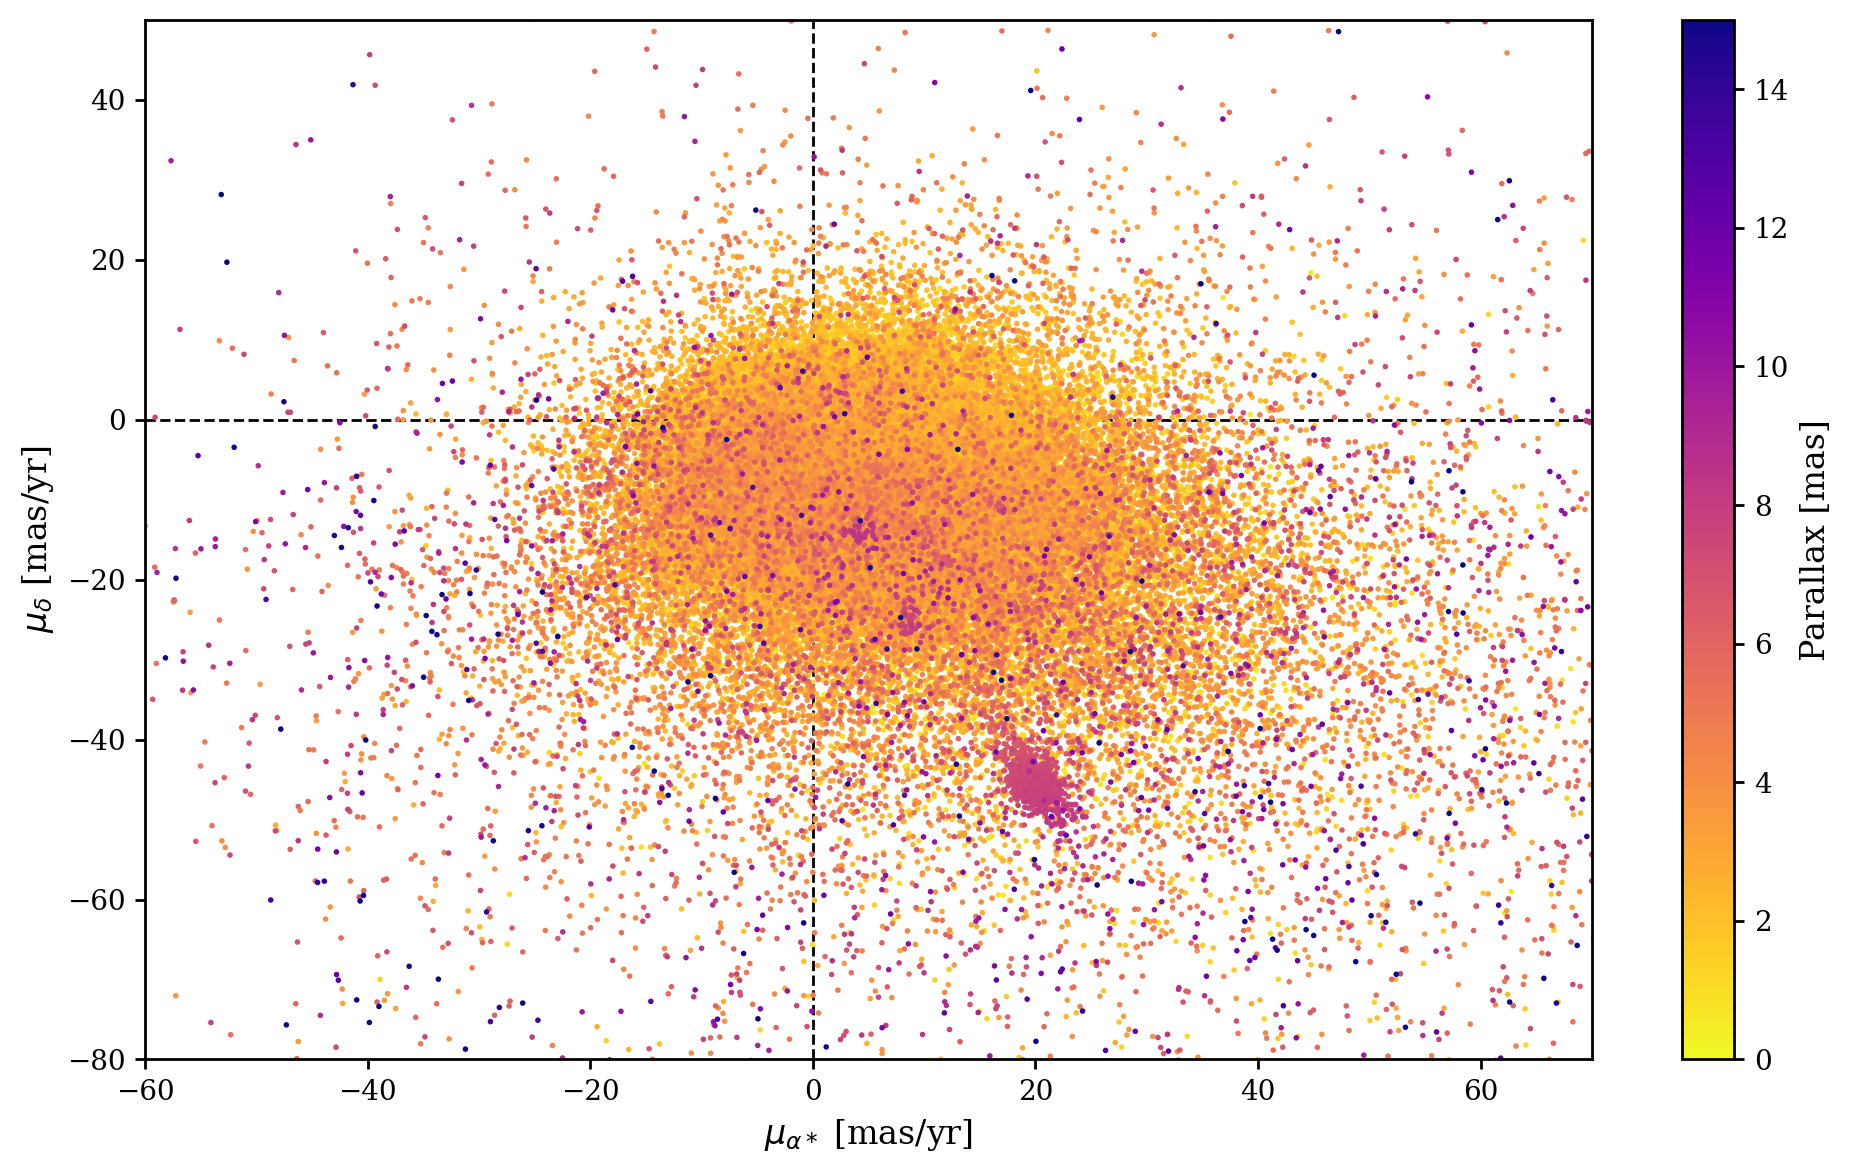

In [10]:
## Your code here 



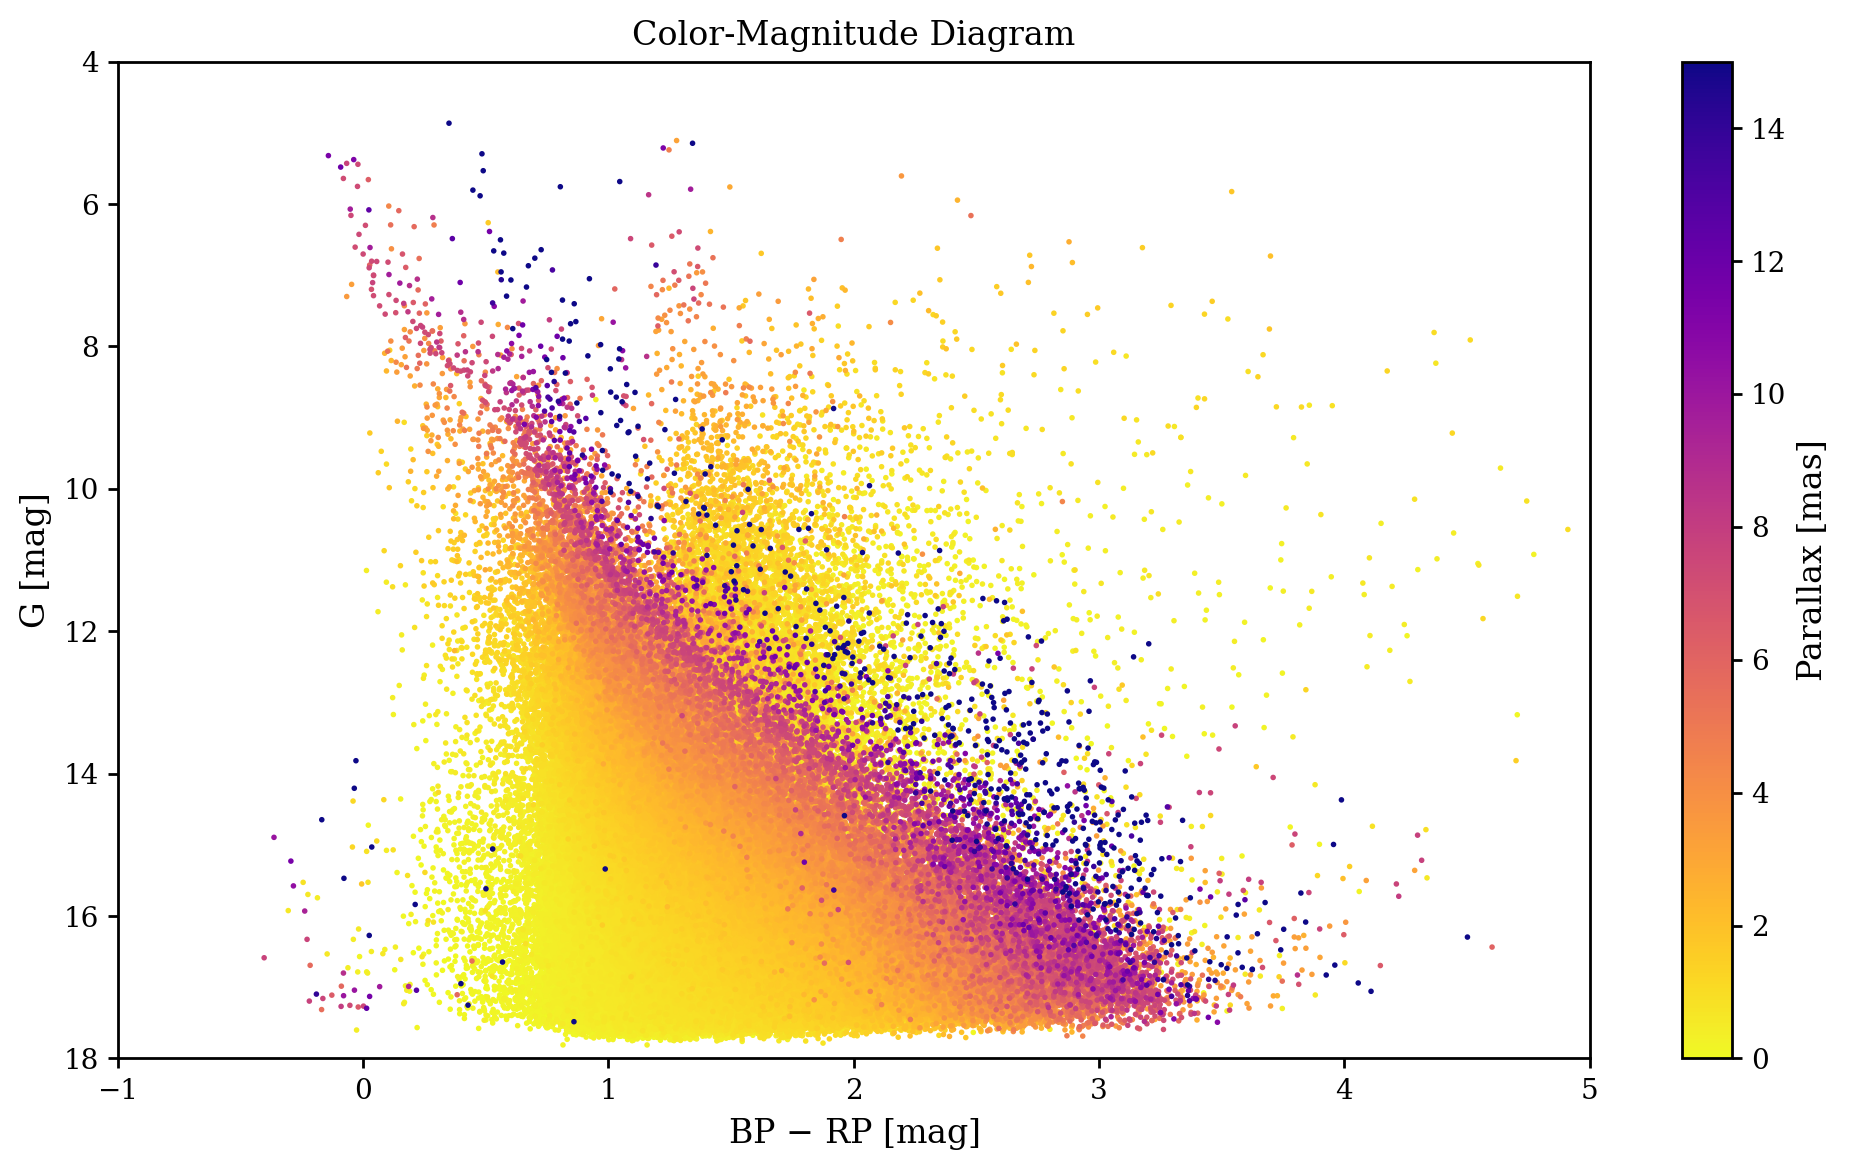

In [11]:
## Your code here 



:::{tip} Exercise 3 

Now we are going to apply a clustering algorithm to find hidden substructure in this data -- i.e., large numbers of stars that share a similar position, distance, and velocity: stellar clusters! 

1. Install and import hdbscan (`!pip install hdbscan`; `import hdbscan`). You may need to install additional dependencies (e.g. `Microsoft Visual C++ 14.0`) to get it to work. 
2. Use a robust scaler from scikit-learn to scale the features by their median and interquartile range. This is helpful for clustering algorithms (and many machine learning algorithms in general) to remove disparate scales from the data. Use ra, dec, parallax, pmra, and pmdec as your features. 
3. Run hdbscan on your scaled data. Use a minimum cluster size of 1000 and a minimum number of samples of 10. 
4. Print out the number of stars that belong to each discovered cluster. 
:::

In [13]:
## Your code here 



array([  1104,  16961, 319825], dtype=int64)

:::{tip} Exercise 4 

Now it's time to visualize your discovered clusters. 

1. Plot the clusters in proper motion space and color them by cluster number. 
2. Plot the clusters in the Gaia color-magnitude diagram and color them by cluster number.
:::

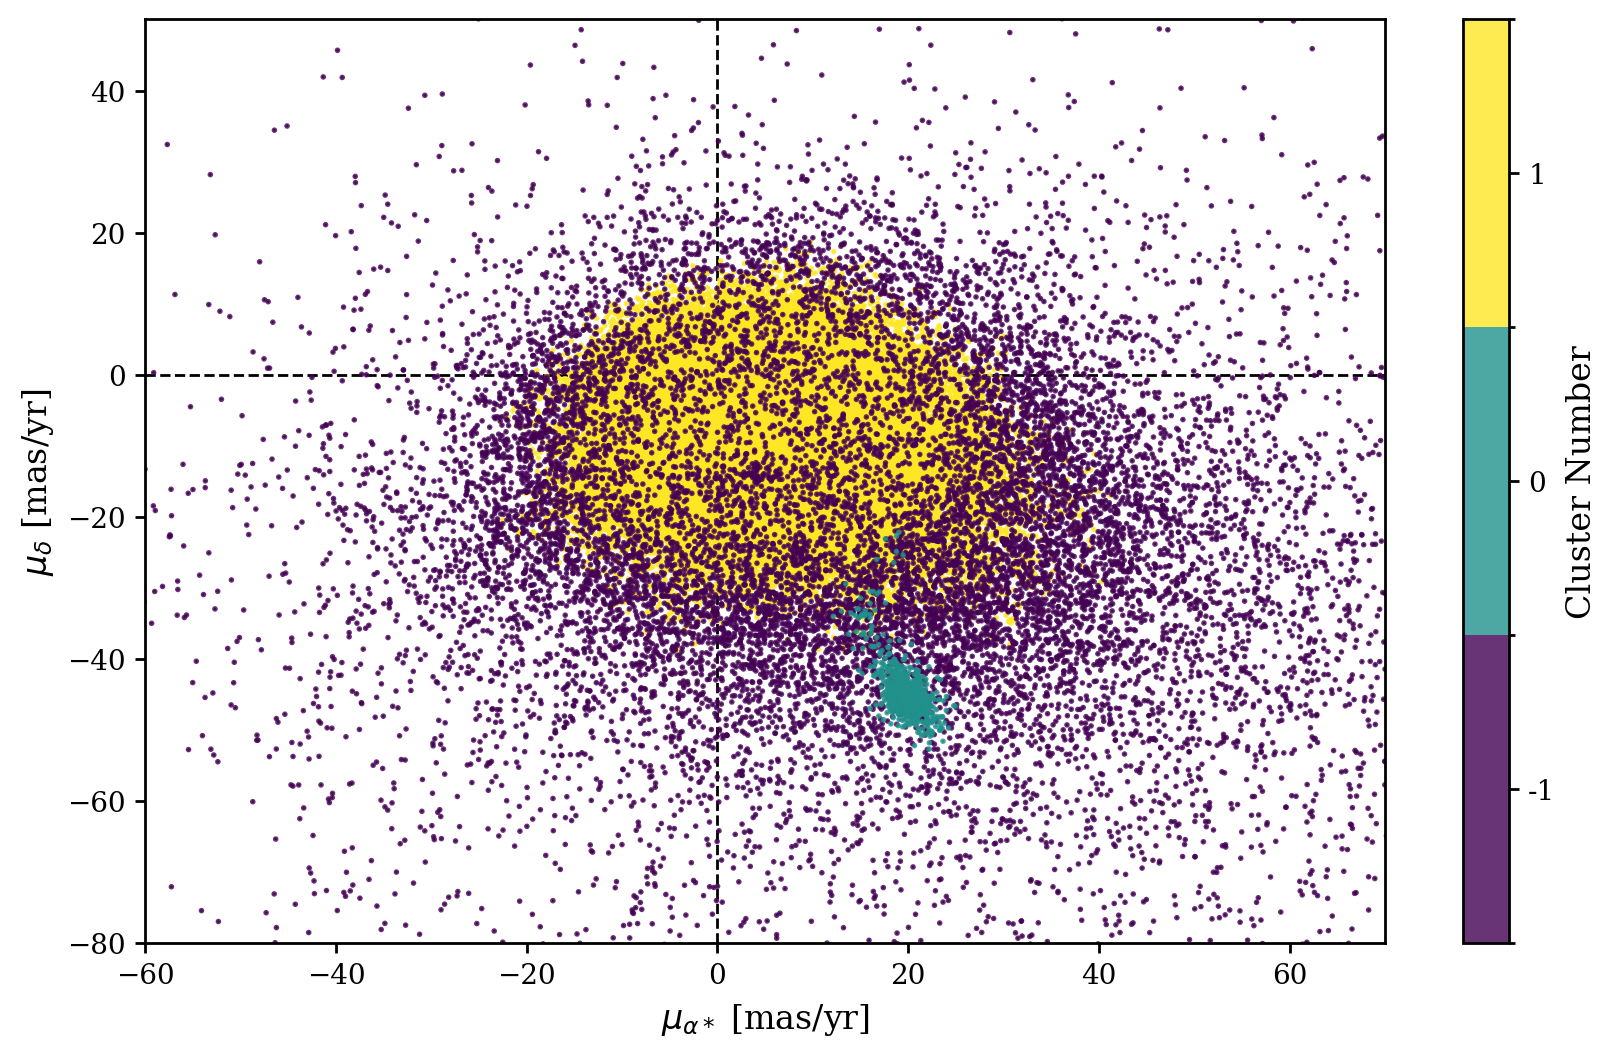

In [14]:
## Your code here 



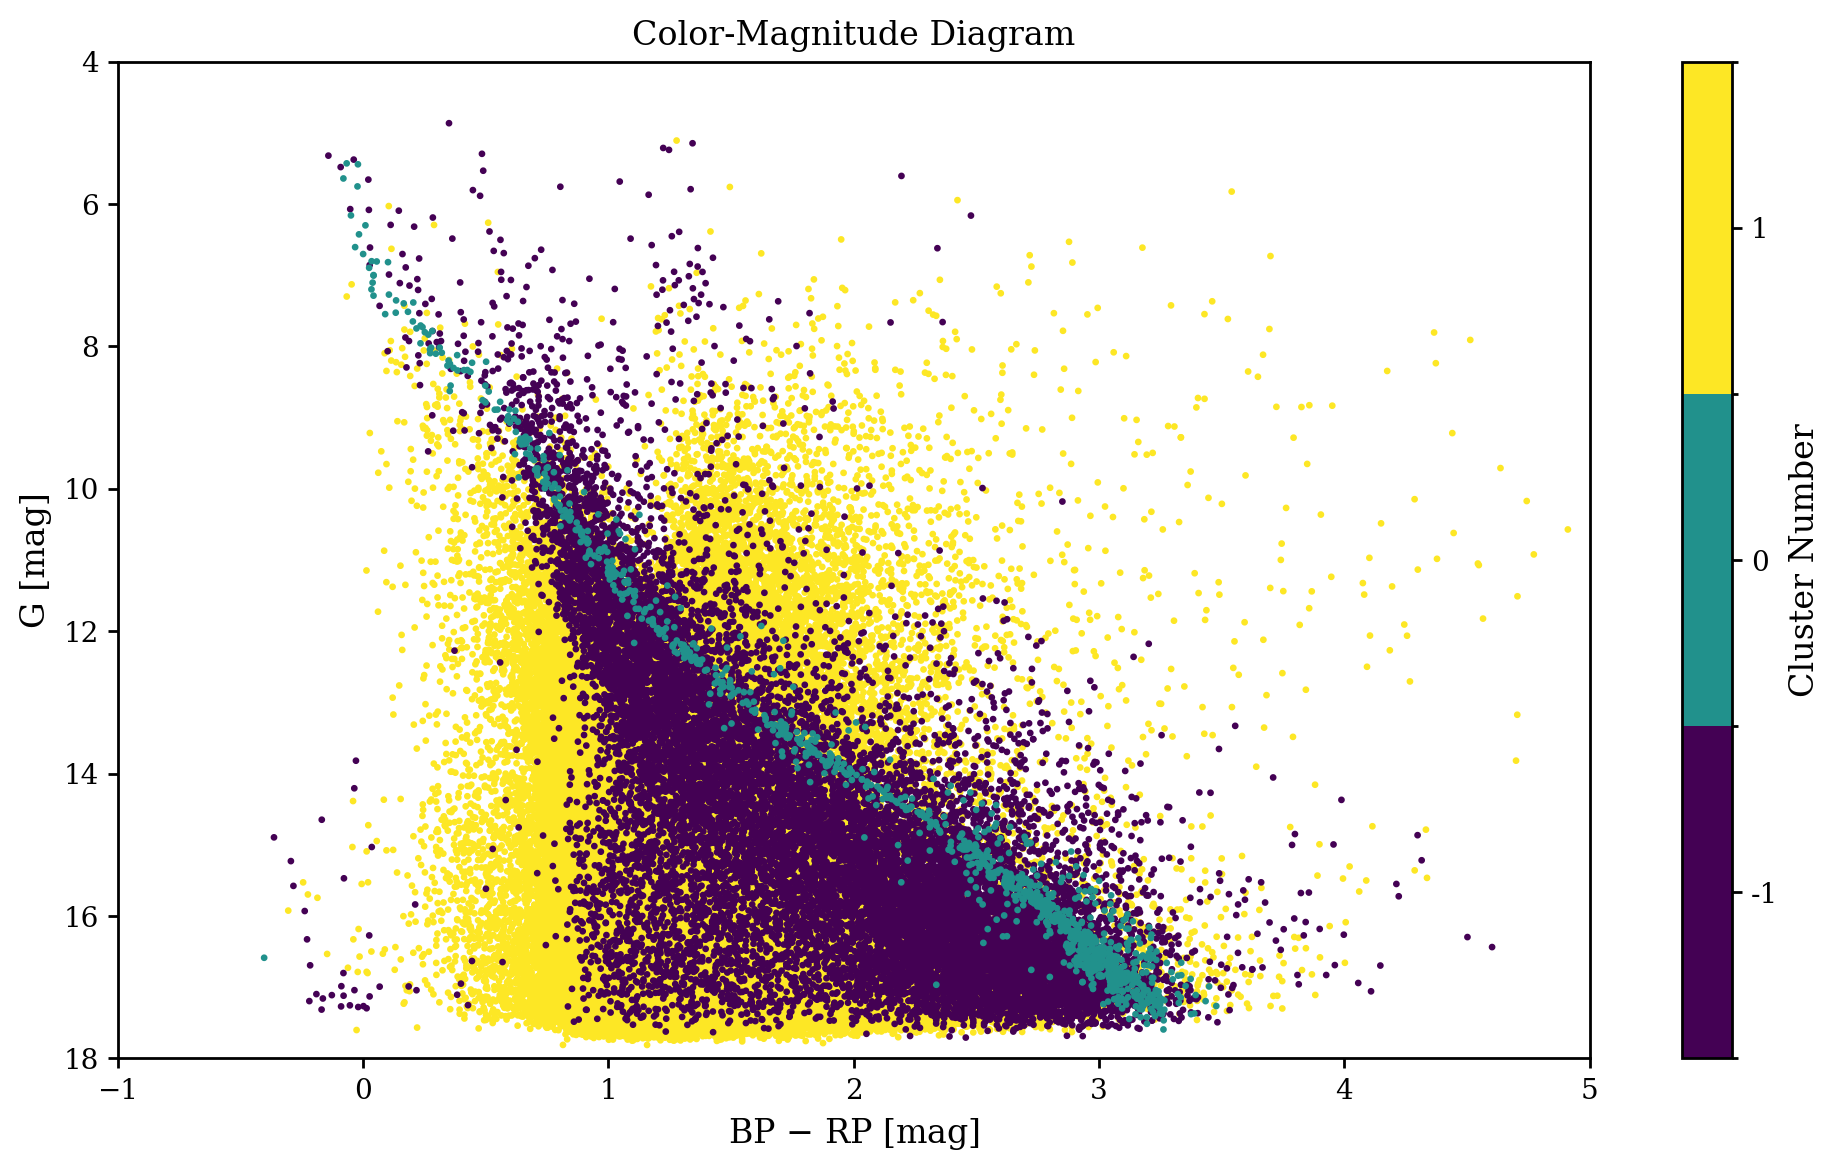

In [15]:
## Your code here 



Far out! We discovered the Pleiades. It's the highly-structured teal band. 

HDBSCAN output two other "clusters". One is the noise label, given by -1, and the other is just the rest of the stars. 

In fact, there are many other clusters hidden in the remaining data, but for now we will focus on the Pleiades. 

:::{note} Extra credit 1 

Build an interactive plot that allows you to use a slider to select which cluster is plotted in the color-magnitude diagram, with the rest of the stars shown as gray in the background. 
:::

In [ ]:
## Your extra credit code here 



:::{tip} Exercise 5

Open stellar clusters appear as simple stellar populations: all stars have the same age and chemical composition, differing only in their mass. 

A stellar evolution code such as [MESA](https://docs.mesastar.org/) can be used to compute the evolution of stars with different masses and the same composition. With this information, it is possible to construct an isochrone (iso: same, chrone: age; named here at Yale by Pierre Demarque) giving how stars of the same age but different mass vary their properties. These simple stellar populations therefore provide a great opportunity to compare models with observations. 

I have uploaded to canvas an isochrone from [MIST](https://waps.cfa.harvard.edu/MIST/) (MESA Isochrones & Stellar Tracks) with an age of 140 Myr, named `mist_isochrone_140Myr.dat`. 

1. Parse the isochrone file. Print out the names of the columns. 
2. Plot the color-magnitude diagram of the observed cluster and the isochrone. You will need to increase the magnitudes (by about 6) and colors (by about 0.15) of the isochrone to account for the distance and reddening. The columns you'll need are `Gaia_BP_EDR3`, `Gaia_RP_EDR3`, and `Gaia_G_EDR3`. 
3. Write down: What kinds of stars belong to this cluster? For what kinds of stars is the isochrone a good match? A bad match? Why do you think that might be so? 
:::

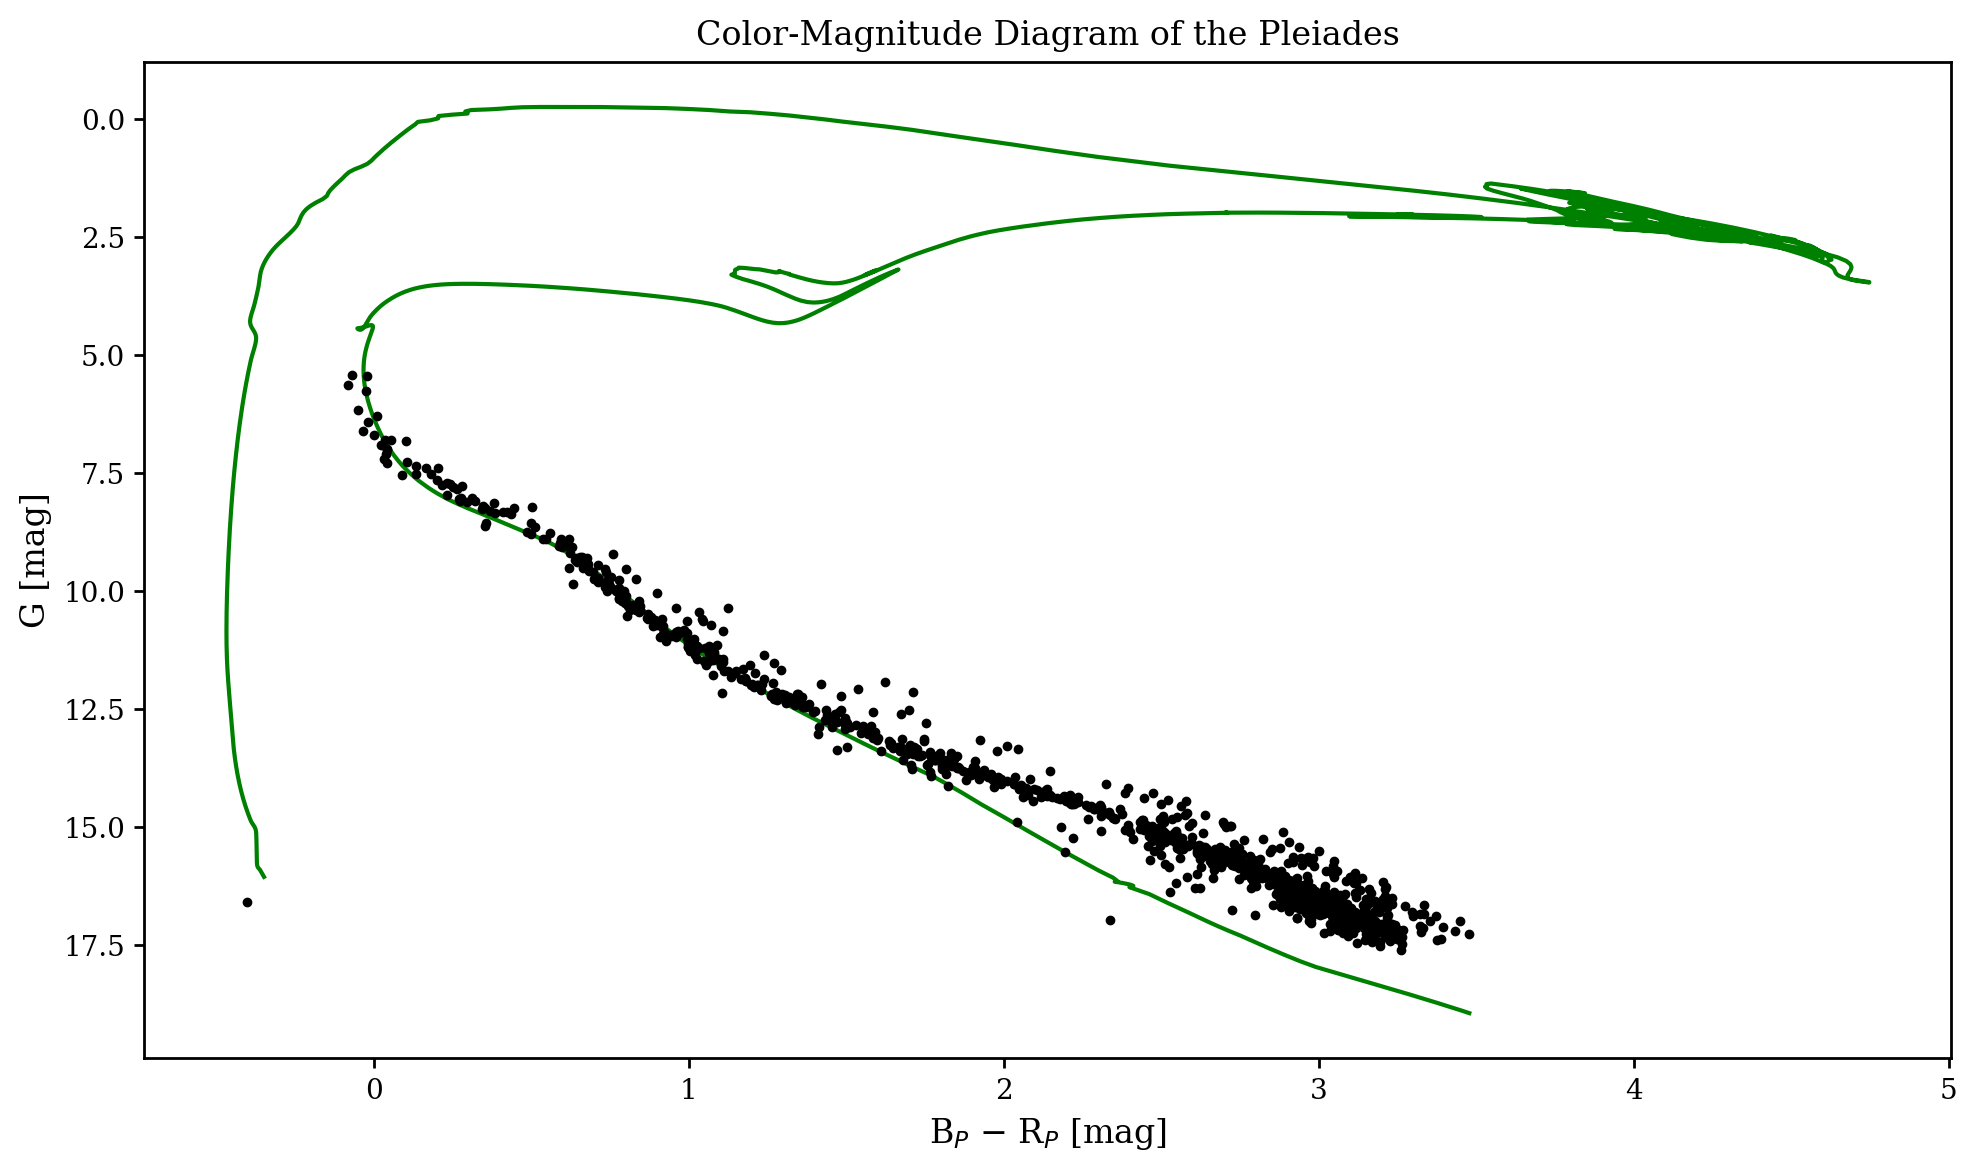

In [19]:
## Your code here 



:::{tip} Exercise 6

I have provided code below to make a 3D map of a star cluster, using ipython widgets to control the orientation. Get it to visualize your discovered cluster! 

Since the measurements have noise, I have provided a "random seed" slider that perturbs each parallax measurement with noise drawn from a normal distribution according to the uncertainty. 
:::

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets

@np.vectorize
def spherical_to_cartesian(ra, dec, distance):
    x = np.cos(np.radians(dec)) * np.cos(np.radians(ra)) * distance
    y = np.cos(np.radians(dec)) * np.sin(np.radians(ra)) * distance
    z = np.sin(np.radians(dec)) * distance
    return x, y, z

ra = np.array(pleiades['ra'])
dec = np.array(pleiades['dec'])
parallax = np.array(pleiades['parallax']) / 1000
parallax_error = np.array(pleiades['parallax_error']) / 1000
g_mag = np.array(pleiades['phot_g_mean_mag'])

def recompute_positions(seed):
    if seed > 0:
        np.random.seed(seed)
        distance = np.array(1 / np.random.normal(parallax, parallax_error))
    else:
        distance = np.array(1 / parallax)
    
    x, y, z = spherical_to_cartesian(ra, dec, distance)
    x_centered = x - np.median(x)
    y_centered = y - np.median(y)
    z_centered = z - np.median(z)
    
    return x_centered, y_centered, z_centered, distance

def plot_pleiades_centered(angle_azim, angle_elev, zoom, random_seed):
    x_centered, y_centered, z_centered, distance = recompute_positions(random_seed)
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(x_centered, y_centered, z_centered, c=distance, s=2.5**(30/g_mag), cmap='cool', alpha=0.6)
    ax.set_xlabel('X (pc)')
    ax.set_ylabel('Y (pc)')
    ax.set_zlabel('Z (pc)')
    ax.view_init(elev=angle_elev, azim=angle_azim)
    ax.set_xlim(-zoom, zoom)
    ax.set_ylim(-zoom, zoom)
    ax.set_zlim(-zoom, zoom)
    plt.colorbar(sc, label='Distance (pc)')
    plt.show()

widgets.interact(plot_pleiades_centered,
                 angle_azim=widgets.IntSlider(min=0, max=360, step=1, value=180),
                 angle_elev=widgets.IntSlider(min=-90, max=90, step=1, value=30),
                 zoom=widgets.IntSlider(min=1, max=45, value=20),
                 random_seed=widgets.IntSlider(min=0, max=128, value=0));

:::{note} Extra Credit 2 

Improve on the above 3D visualization. You can be creative. 

One idea could be that instead of coloring the stars by their distance, you color them by how they would actually appear (accoring to their temperature, for example using [this scheme](https://en.wikipedia.org/wiki/Stellar_classification#Harvard_spectral_classification)), and resize them according to their radius. 
:::

In [21]:
## Your extra credit code here 



:::{note} Extra Credit 3

Find one or more other clusters in this data. 

To help guide your search, I have uploaded `known_clusters.dat` to canvas containing the positions of the ~7,000 currently known open clusters. 

It will help to remove the members of the Pleiades from your data before running HDBSCAN again. Take a look at how many known members are in the clusters below (given in parentheses after their names) and set your scan parameters accordingly. 

Here are a couple of plots to inspire your search. 
:::

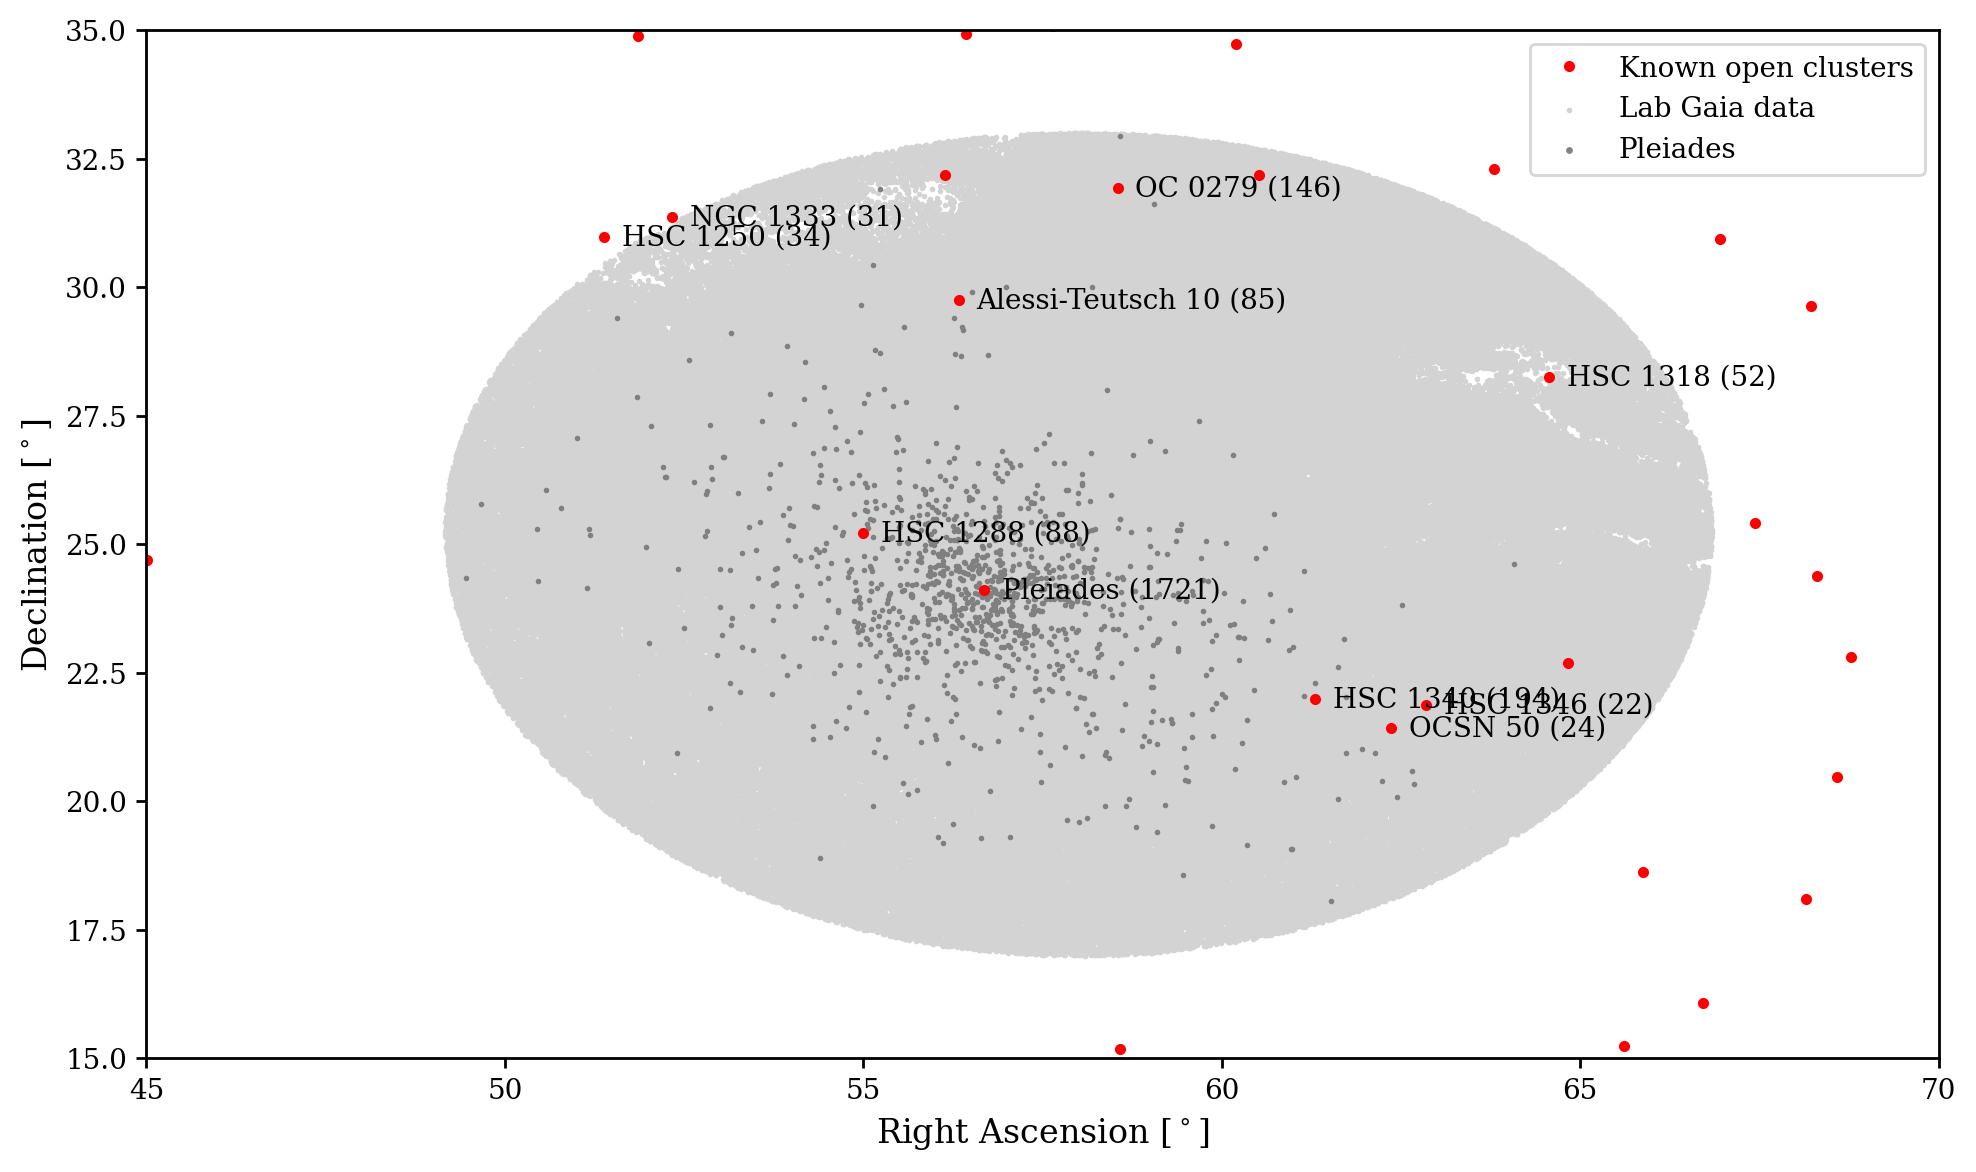

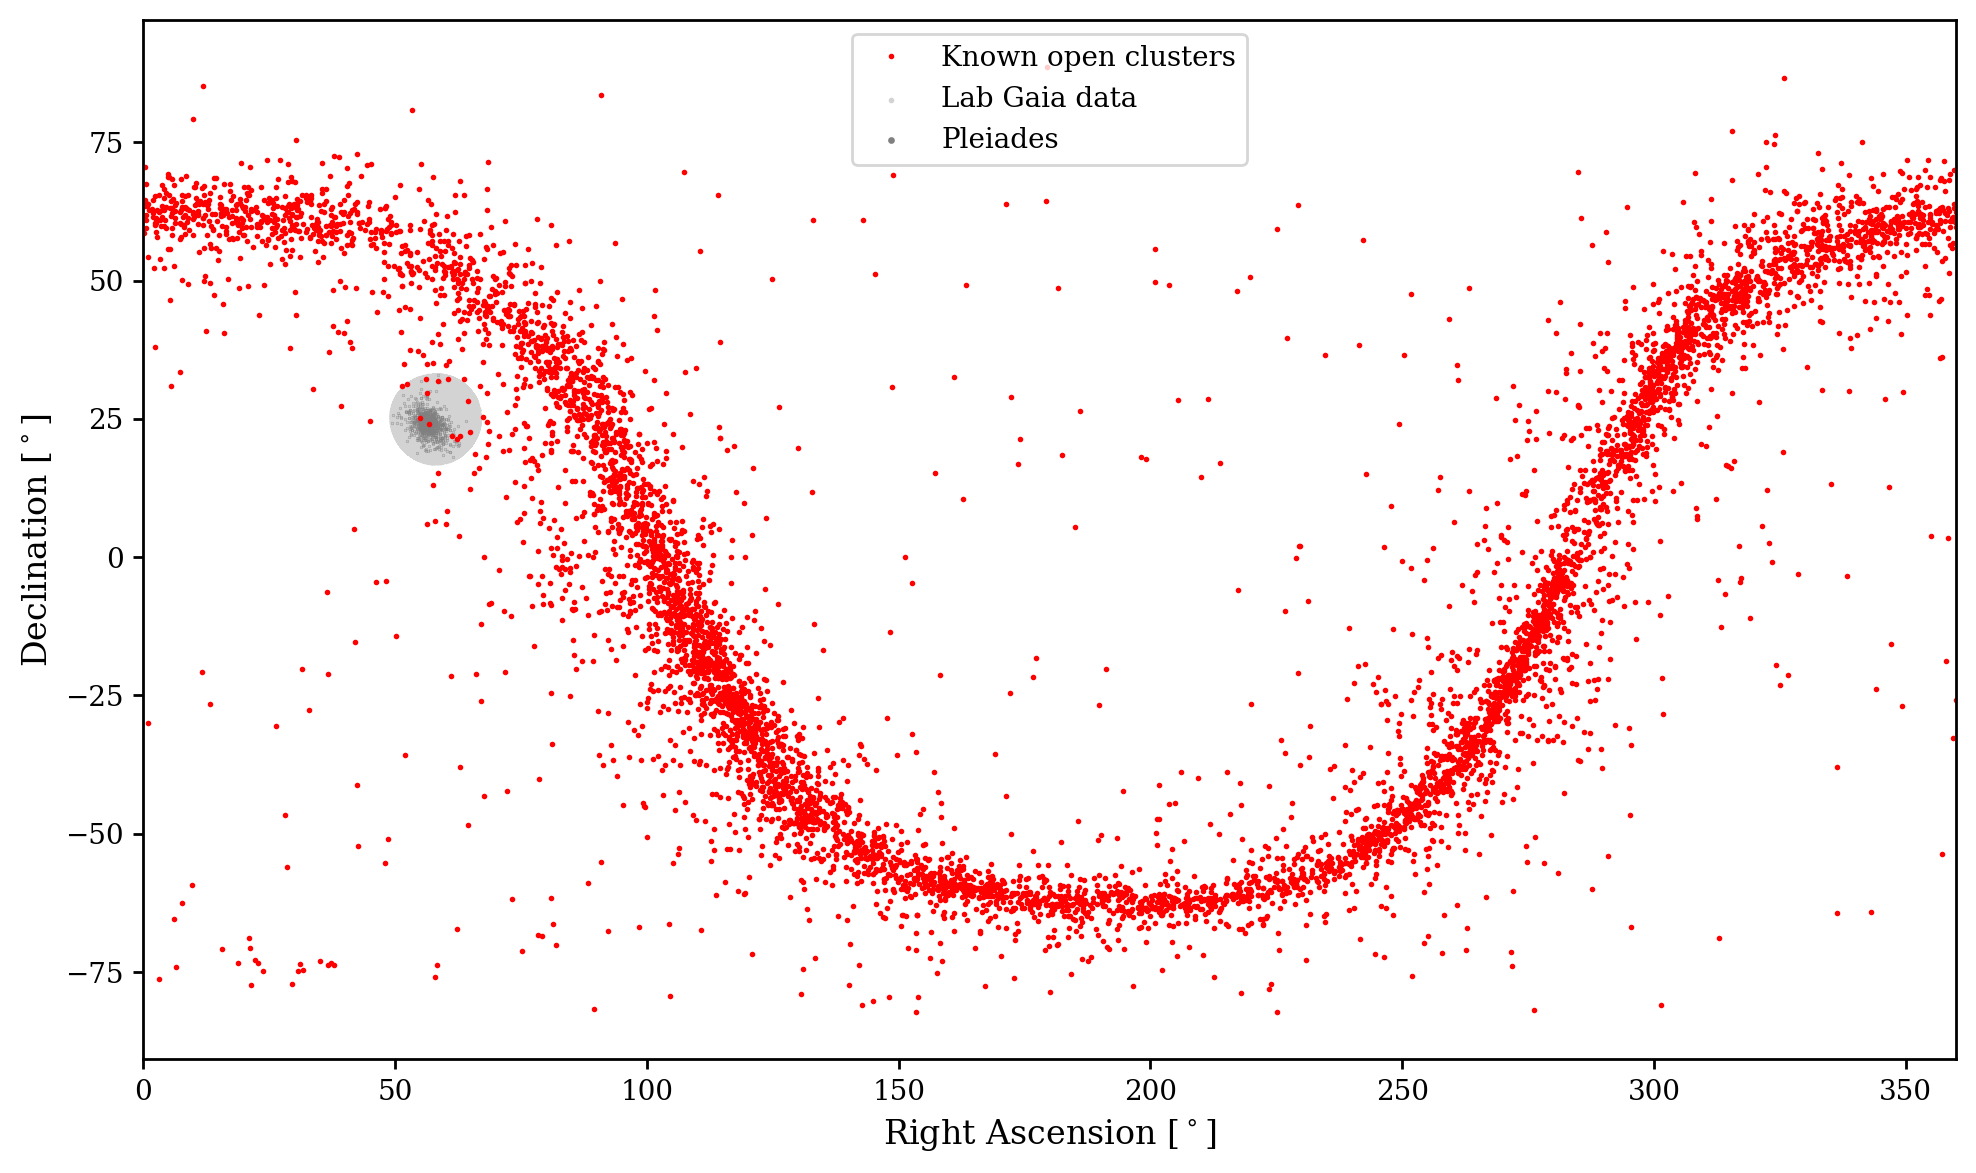

In [24]:
## Your extra credit code here 



ChatGPT link: 